Adapted from https://www.learnopencv.com/image-classification-using-transfer-learning-in-pytorch/

In [16]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
import time

In [2]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [3]:
# Load the Data
 
# Set train and valid directory paths
train_directory = '../../car-images/Train'
valid_directory = '../../car-images/Validate'
test_directory = '../../car-images/Test'
 
# Batch size
bs = 32
 
# Number of classes (front of car or not)
num_classes = 2
 
# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}
 
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])
 
# Create iterators for the Data loaded using DataLoader module
train_data = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data = DataLoader(data['test'], batch_size=bs, shuffle=True)
 
# Print the train, validation and test set data sizes
train_data_size, valid_data_size, test_data_size

(1499, 250, 1036)

In [6]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/cardetector/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 104MB/s] 


Canziani et al. (https://arxiv.org/pdf/1605.07678.pdf) list many pretrained models that are used for various practical applications, analyzing the accuracy obtained and the inference time needed for each model. ResNet50 is one of those having a good tradeoff between accuracy and inference time. When a model is loaded in PyTorch, all its parameters have their ‘requires_grad‘ field set to true by default. That means each and every change to the parameter values will be stored in order to be used in the back propagation graph used for training. This increases memory requirements. So, since most of the parameters in our pre-trained model are already trained for us, we reset the requires_grad field to false.

In [7]:
# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

Then we replace the final layer of the ResNet50 model by a small set of Sequential layers. The inputs to the last fully connected layer of ResNet50 is fed to a Linear layer which has 256 outputs, which are then fed into ReLU and Dropout layers. It is then followed by a 256×10 Linear Layer which has 2 outputs corresponding to the 2 classes in our car image data.

In [10]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features
 
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2), 
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

In [12]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())

In [18]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [20]:
dataset = 'car-images'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print the model to be trained
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 25 epochs
num_epochs = 30
trained_model, history = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/30
Epoch : 000, Training: Loss: 0.1841, Accuracy: 92.3282%, 
		Validation : Loss : 0.0517, Accuracy: 100.0000%, Time: 150.4628s
Epoch: 2/30
Epoch : 001, Training: Loss: 0.2901, Accuracy: 87.4583%, 
		Validation : Loss : 0.2134, Accuracy: 89.2000%, Time: 150.2779s
Epoch: 3/30
Epoch : 002, Training: Loss: 0.1869, Accuracy: 92.4616%, 
		Validation : Loss : 0.0327, Accuracy: 100.0000%, Time: 147.7697s
Epoch: 4/30
Epoch : 003, Training: Loss: 0.1309, Accuracy: 94.7965%, 
		Validation : Loss : 0.0266, Accuracy: 100.0000%, Time: 153.2258s
Epoch: 5/30
Epoch : 004, Training: Loss: 0.1296, Accuracy: 94.9967%, 
		Validation : Loss : 0.0347, Accuracy: 100.0000%, Time: 146.6597s
Epoch: 6/30
Epoch : 005, Training: Loss: 0.1202, Accuracy: 95.5304%, 
		Validation : Loss : 0.0158, Accuracy: 100.0000%, Time: 147.1634s
Epoch: 7/30
Epoch : 006, Training: Loss: 0.1222, Accuracy: 95.1968%, 
		Validation : Loss : 0.0221, Accuracy: 100.0000%, Time: 148.2505s
Epoch: 8/30
Epoch : 007, Training: Loss: 0

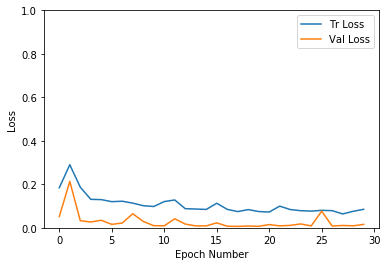

In [21]:

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

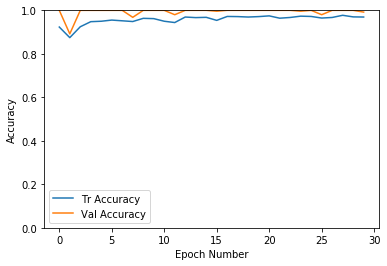

In [22]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [25]:
def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))

In [26]:
computeTestSetAccuracy(trained_model, loss_func)

Test Batch number: 000, Test: Loss: 0.4020, Accuracy: 0.8750
Test Batch number: 001, Test: Loss: 0.1053, Accuracy: 0.9375
Test Batch number: 002, Test: Loss: 0.0120, Accuracy: 1.0000
Test Batch number: 003, Test: Loss: 0.2840, Accuracy: 0.9375
Test Batch number: 004, Test: Loss: 0.2106, Accuracy: 0.9062
Test Batch number: 005, Test: Loss: 0.4999, Accuracy: 0.7812
Test Batch number: 006, Test: Loss: 0.4529, Accuracy: 0.8438
Test Batch number: 007, Test: Loss: 0.4466, Accuracy: 0.8750
Test Batch number: 008, Test: Loss: 0.6579, Accuracy: 0.7500
Test Batch number: 009, Test: Loss: 0.2957, Accuracy: 0.9062
Test Batch number: 010, Test: Loss: 0.6570, Accuracy: 0.7812
Test Batch number: 011, Test: Loss: 0.3110, Accuracy: 0.8438
Test Batch number: 012, Test: Loss: 0.5766, Accuracy: 0.8438
Test Batch number: 013, Test: Loss: 0.3161, Accuracy: 0.8750
Test Batch number: 014, Test: Loss: 0.2694, Accuracy: 0.8750
Test Batch number: 015, Test: Loss: 0.3147, Accuracy: 0.8438
Test Batch number: 016, 

In [45]:
from PIL import Image

def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(2, dim=1)
        
        # Convert indices to classes
        idx_to_class = {val: key for key, val in    
                                      data['test'].class_to_idx.items()}
        
        for i in range(2):
            print("Prediction", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])

Prediction 1 : Front-View , Score:  0.9999746
Prediction 2 : Not-Front-View , Score:  2.540321e-05


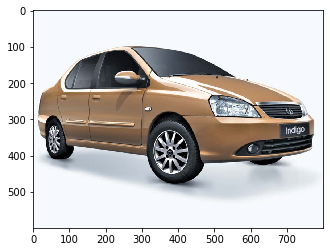

In [46]:
# Test a particular model on a test image


model = torch.load(dataset+'_model_29.pt')
# model_number.pt, where number = epoch
predict(model, '../../car-images/Test/Front-View/tata16.jpg')

# Load Data from folders
#computeTestSetAccuracy(model, loss_func)

Prediction 1 : Not-Front-View , Score:  0.9999099
Prediction 2 : Front-View , Score:  9.0080925e-05


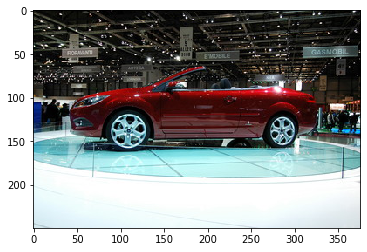

In [47]:

predict(model, '../../car-images/Test/Not-Front-View/tripod_seq_02_094.jpg')